In [77]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Binarizer, LabelEncoder, MaxAbsScaler, MinMaxScaler, OneHotEncoder, \
    OrdinalEncoder, RobustScaler, StandardScaler

# Exercise 2 - Debugging - Drugs

The dataset contains a set of patients, all of whom suffered from the same illness.
During their course of treatment, each patient responded to one of 5 medications: Drug A, Drug B, Drug c, Drug x or y.

This complex dataset proposes a set of challenges that you'll try to overcome. A basic ML pipeline is already in place. You have to optimize the performance of the model by applying good practices, debugging pre-processing errors, etc.

**Rules**:
- Do not use other modules than those already imported *(or do it only if your own code is not working. In this case, keep your own code in the notebook, commented, so that we know what you tried)*.
- Explain **all** of your choices. For every task, choose the most appropriate option for this problem and describe your choice.
- You can modify any parts of the code or replace the model by one already used in previous PWs.

**Work to do**:
- [ ] Apply a type of normalization.
- [ ] Encode categorical data.
- [ ] Use all columns in the dataset (or choose the most meaningful features).
- [ ] Choose a more appropriate metric.
- [ ] Optimize hyper-parameters.
- [ ] Test the model performance correctly using a separated test set.
- Apply **two** of those techniques:
  - [ ] Keep relative class frequencies in the train/test sets (check train_test_split docs)
  - [ ] Show which feature(s) are the most correlated to the target.
  - [ ] Use cross-validation.

In [78]:
df = pd.read_csv("drug.csv")
df.head()

,age,sex,bp,cholesterol,Na_to_K,drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          200 non-null    int64  
 1   sex          200 non-null    object 
 2   bp           200 non-null    object 
 3   cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [80]:
categorical_columns = ["sex", "bp", "cholesterol", "drug"]

# encode categorical columns
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [81]:
X = df.drop(columns="drug")
y = df["drug"]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# TODO: a preprocessing step is likely missing here...
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [99]:
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [100]:
def predict(estimator, X, y):
    # predict
    y_pred = estimator.predict(X)
    
    # show confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    disp.plot();
    
    # check metric (this one is probably not the best choice...)
    # change to f1-score
    metric = metrics.f1_score(y, y_pred, average='weighted')
    print(f"F1-score : {metric:.2f}")
    

F1-score : 1.00


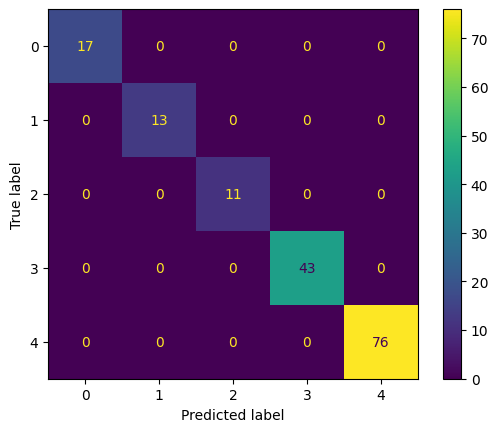

In [101]:
predict(knn, X_train, y_train)

#### First technique : rebalanced dataset

In [87]:
# Keep relative class frequencies in the train/test sets (check train_test_split docs)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [88]:
scaler_balanced = StandardScaler()
X_train_balanced = scaler_balanced.fit_transform(X_train_balanced)
X_test_balanced = scaler_balanced.transform(X_test_balanced)

F1-score : 0.91


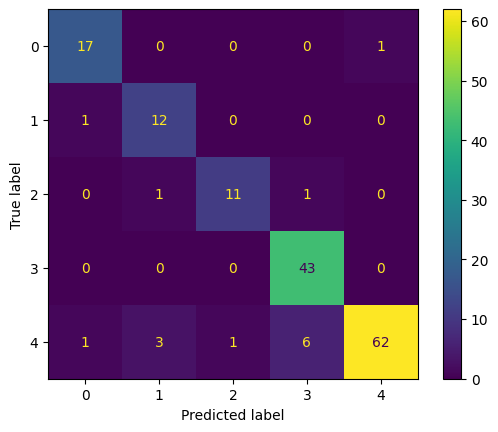

In [89]:
knn = KNeighborsClassifier(5)
knn.fit(X_train_balanced, y_train_balanced)
predict(knn, X_train_balanced, y_train_balanced)

#### Second technique : explore correlation

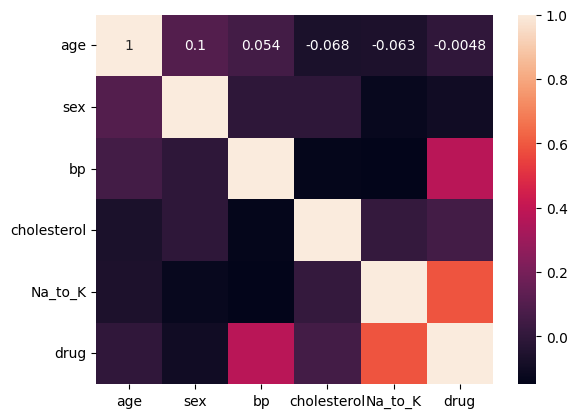

In [90]:
# plot the correlation matrix
import seaborn as sns
sns.heatmap(df.corr(), annot=True);

It seems that the most correlated features are bp and Na_to_K. Let's try to use only those features for the model.

In [91]:
df_reduced = df.drop(["age", "sex", "cholesterol"], axis=1)
df_reduced.head()

,bp,Na_to_K,drug
0,0,25.355,4
1,1,13.093,2
2,1,10.114,2
3,2,7.798,3
4,1,18.043,4


In [92]:
X_reduced = df_reduced.drop(columns="drug")
y_reduced = df_reduced["drug"]

In [93]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42, stratify=y_reduced)

In [94]:
scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)

F1-score : 0.89


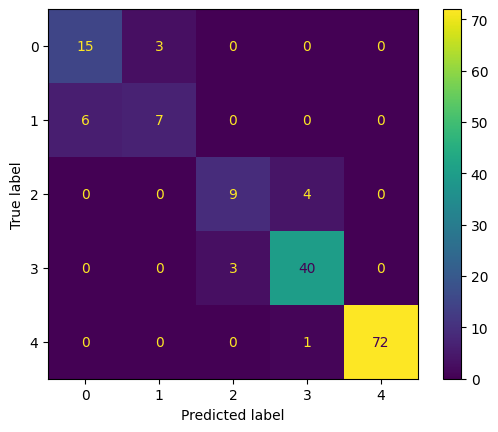

In [95]:
knn = KNeighborsClassifier(5)
knn.fit(X_train_reduced, y_train_reduced)
predict(knn, X_train_reduced, y_train_reduced)

We can denote that even if there's a slight loss of performance, the model with only those two features is still very performant with a f1-score of 0.89.

### Third technique : cross-validation and hyperparameter tuning

{'n_neighbors': 1}
0.8863242491956995


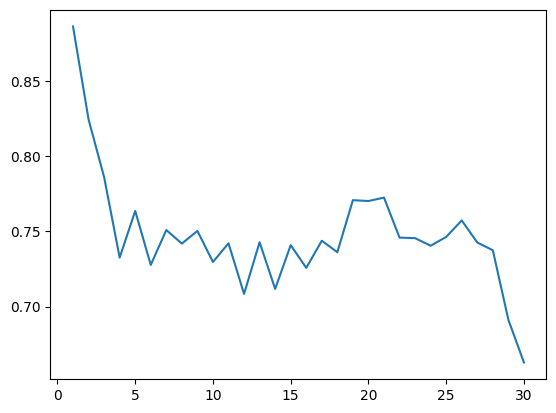

In [102]:
# use cross-validation to find the best k
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = model_selection.GridSearchCV(knn, param_grid, scoring='f1_weighted')
grid.fit(X_train_balanced, y_train_balanced)

# plot the results
import matplotlib.pyplot as plt
plt.plot(k_range, grid.cv_results_['mean_test_score']);

# print the best k
print(grid.best_params_)
print(grid.best_score_)

The best number of neighbors is 1, with a f1-score of 0.88